In [1]:
import numpy as np
import torch
import nflows

import matplotlib
import matplotlib.pyplot as plt
# %matplotlib widget

import corner

import seaborn as sns
sns.set()

In [2]:
import sys
sys.path.append('/home/sebastian/Documents/projects/density-deconvolution-astro')

In [3]:
device = torch.device("cpu")

# Create data

In [4]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((100_000,)).reshape((-1, 2))

/home/sebastian/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


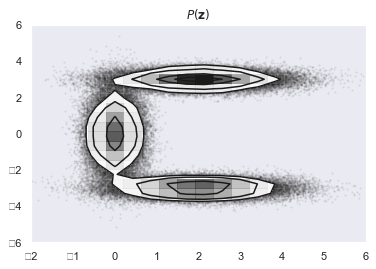

In [5]:
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]

x_lim = (-2, 6)
y_lim = (-6, 6)

fig, ax = plt.subplots()
corner.hist2d(Z_train[:, 0].numpy(), Z_train[:, 1].numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{z})$');

# Add error

/home/sebastian/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


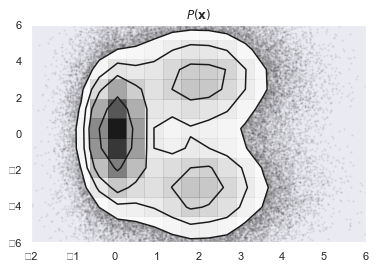

In [6]:
S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]

fig, ax = plt.subplots()
corner.hist2d(X_train[:, 0].numpy(), X_train[:, 1].numpy())
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{x})$');

In [7]:
# Train 

In [8]:
from deconv.gmm.data import DeconvDataset

train_data = DeconvDataset(X_train, torch.linalg.cholesky(S.repeat(X_train.shape[0], 1, 1)))
test_data = DeconvDataset(X_test, torch.linalg.cholesky(S.repeat(X_test.shape[0], 1, 1)))

In [9]:
# from deconv.gmm.sgd_deconv_gmm import SGDDeconvGMM

# gmm = SGDDeconvGMM(
#     3,
#     2,
#     batch_size=200,
#     lr=1e-1,
#     epochs=100,
#     #device=torch.device('cpu')
# )
# gmm.fit(train_data, verbose=True)

In [10]:
S.shape

torch.Size([2, 2])

In [11]:
from deconv.flow.svi import SVIFlow
svi = SVIFlow(
    2,
    5,
    device=torch.device("cpu"),
    batch_size=512,
    epochs=20,
    lr=1e-4,
    n_samples=50,
    use_iwae=False
)

In [12]:
%%time
svi.fit(train_data, val_data=None)

Epoch 0, Train Loss: -5.543304371744791
Epoch 1, Train Loss: -4.245751629231771
Epoch 2, Train Loss: -4.169015118815104
Epoch 3, Train Loss: -4.1510141259765625
Epoch 4, Train Loss: -4.141464063313802
Epoch 5, Train Loss: -4.13246401529948
Epoch 6, Train Loss: -4.126996359049479
Epoch 7, Train Loss: -4.120844773763021
Epoch 8, Train Loss: -4.116607666015625
Epoch 9, Train Loss: -4.113046325683594
Epoch 10, Train Loss: -4.110279856770833
Epoch 11, Train Loss: -4.106656272786458
Epoch 12, Train Loss: -4.10395759765625
Epoch 13, Train Loss: -4.102115085449219
Epoch 14, Train Loss: -4.100856943359375
Epoch 15, Train Loss: -4.097935094401041
Epoch 16, Train Loss: -4.096913370768229
Epoch 17, Train Loss: -4.095198654785157
Epoch 18, Train Loss: -4.094543971354167
Epoch 19, Train Loss: -4.09373449625651


/home/sebastian/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


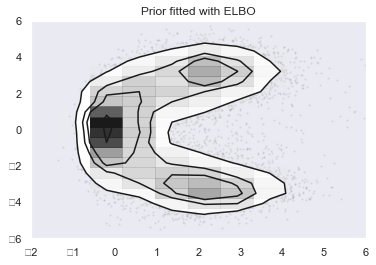

In [22]:
torch.set_default_tensor_type('torch.FloatTensor')
prior_samples = svi.sample_prior(10_000)

fig, ax = plt.subplots()
corner.hist2d(prior_samples[0, :, 0].numpy(), prior_samples[0, :, 1].numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Prior fitted with ELBO');

In [14]:
mean = np.array([[3.0, 0.0], [0.0, 0.0]])
cov = np.array([
    [
        [0.1, 0],
        [0, 3]
    ],
    [
        [0.1, 0],
        [0, 3]
    ]
])
test_point = [
    torch.Tensor(mean).to(svi.device),
    torch.cholesky(torch.Tensor(cov)).to(svi.device)
]
torch.set_default_tensor_type('torch.FloatTensor')
posterior_samples = svi.resample_posterior(test_point, 10000)

from deconv.gmm.plotting import plot_covariance
fig, ax = plt.subplots()
corner.hist2d(posterior_samples[0, :, 0].numpy(), posterior_samples[0, :, 1].numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Recognition network samples for test point, fitted using ELBO.');

<ipython-input-14-6c7cbf862365>:14: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1658220902664/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1744.)
  torch.cholesky(torch.Tensor(cov)).to(svi.device)


AttributeError: 'list' object has no attribute 'shape'

In [15]:
rsamples = svi.resample_posterior(test_point, 10000)

fig, ax = plt.subplots()
corner.hist2d(rsamples[0, :, 0].cpu().numpy(), rsamples[0, :, 1].cpu().numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Resampled posterior for test point, fitted using ELBO.')

AttributeError: 'list' object has no attribute 'shape'